CMPE 258 Final Project Python 2.7 Version
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 05/06/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [2]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

# state control
state = 1
np.random.seed(state)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
%matplotlib inline
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_PATH = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/'
DATA_PATH = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/data/'
MODEL_PATH = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/'
LOG_PATH = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/log/'
WEIGHT_PATH = '/home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/weight/'

In [3]:
X_train = np.load(DATA_PATH + 'X_train_ori.npy')
y_train = np.load(DATA_PATH + 'y_train_ori.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((30, 512, 512, 1), (30, 512, 512, 1), (30, 512, 512, 1))

In [4]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((27, 512, 512, 1), (3, 512, 512, 1), (27, 512, 512, 1), (3, 512, 512, 1))

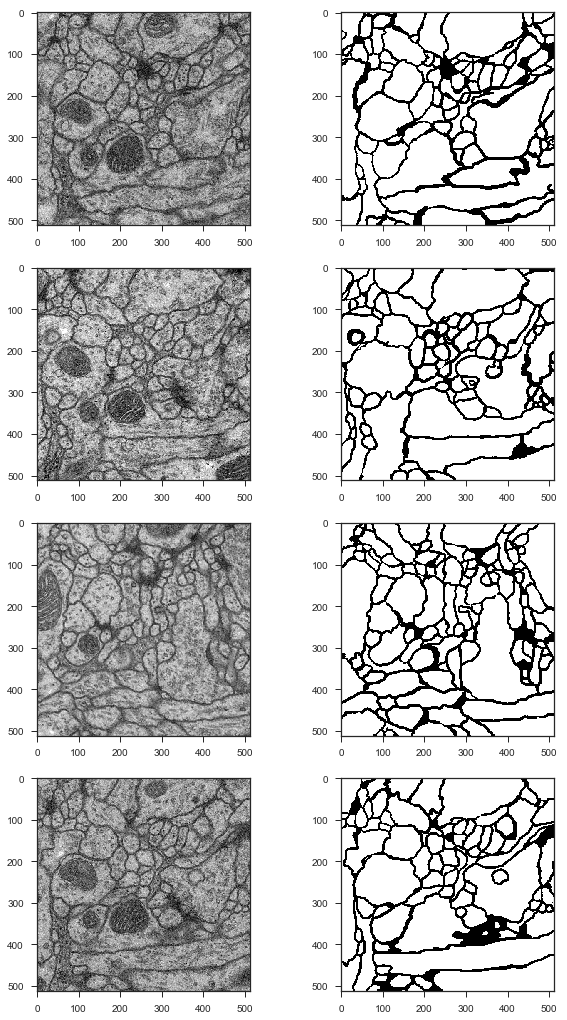

In [5]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 18))
for row in range(4):
    ax[row, 0].imshow(X_train[row].reshape(512, 512), cmap='gray')
    ax[row, 1].imshow(y_train[row].reshape(512, 512), cmap='binary')
    
plt.show()

In [7]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from Loss_Functions import cross_entropy_balanced
from ResNet_UNet_Side_Fuse import u_res_side_fuse_v2
from Loss_Functions import dice_coef

In [8]:
model_unet_side_fuse = u_res_side_fuse_v2(input_shape=(512, 512, 1))
model_unet_side_fuse.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
pre-process (Lambda)            (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 16) 416         pre-process[0][0]                
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 16) 64          conv1[0][0]                      
__________________________________________________________________________________________________
act1 (Acti

In [11]:
lr_decay = ReduceLROnPlateau(monitor='train_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-5)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_RES_Fuse_v2', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_side_fuse.compile(loss={'o1': cross_entropy_balanced,
                                'o2': cross_entropy_balanced,
                                'o3': cross_entropy_balanced,
                                'o4': cross_entropy_balanced,
                                'o5': cross_entropy_balanced,
                                'ofuse': cross_entropy_balanced,
                                },
                          metrics={'ofuse': dice_coef},
                          optimizer=optimizer)

results = model_unet_side_fuse.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=4, epochs=100, callbacks=callback_list, verbose=2)

Train on 27 samples, validate on 3 samples


Epoch 1/100


 - 8s - loss: 0.2697 - o1_loss: 0.1060 - o2_loss: 0.0481 - o3_loss: 0.0371 - o4_loss: 0.0254 - o5_loss: 0.0258 - ofuse_loss: 0.0273 - ofuse_dice_coef: 0.8888 - val_loss: 1.6727 - val_o1_loss: 0.2004 - val_o2_loss: 0.2167 - val_o3_loss: 0.5013 - val_o4_loss: 0.2781 - val_o5_loss: 0.2440 - val_ofuse_loss: 0.2321 - val_ofuse_dice_coef: 0.7566



Epoch 00001: val_loss improved from inf to 1.67274, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 2/100


 - 6s - loss: 0.2646 - o1_loss: 0.1075 - o2_loss: 0.0494 - o3_loss: 0.0330 - o4_loss: 0.0237 - o5_loss: 0.0243 - ofuse_loss: 0.0266 - ofuse_dice_coef: 0.8927 - val_loss: 1.7480 - val_o1_loss: 0.1973 - val_o2_loss: 0.2170 - val_o3_loss: 0.5404 - val_o4_loss: 0.2873 - val_o5_loss: 0.2532 - val_ofuse_loss: 0.2528 - val_ofuse_dice_coef: 0.7625



Epoch 00002: val_loss did not improve
Epoch 3/100


 - 6s - loss: 0.2544 - o1_loss: 0.1067 - o2_loss: 0.0489 - o3_loss: 0.0291 - o4_loss: 0.0219 - o5_loss: 0.0226 - ofuse_loss: 0.0253 - ofuse_dice_coef: 0.8918 - val_loss: 1.7479 - val_o1_loss: 0.1988 - val_o2_loss: 0.2238 - val_o3_loss: 0.5291 - val_o4_loss: 0.2855 - val_o5_loss: 0.2548 - val_ofuse_loss: 0.2559 - val_ofuse_dice_coef: 0.7522



Epoch 00003: val_loss did not improve
Epoch 4/100


 - 6s - loss: 0.2415 - o1_loss: 0.1064 - o2_loss: 0.0468 - o3_loss: 0.0243 - o4_loss: 0.0197 - o5_loss: 0.0205 - ofuse_loss: 0.0238 - ofuse_dice_coef: 0.8982 - val_loss: 1.6565 - val_o1_loss: 0.1900 - val_o2_loss: 0.1924 - val_o3_loss: 0.5095 - val_o4_loss: 0.2739 - val_o5_loss: 0.2442 - val_ofuse_loss: 0.2465 - val_ofuse_dice_coef: 0.7620



Epoch 00004: val_loss improved from 1.67274 to 1.65647, saving model to /home/tulan/PycharmProjects/Google/Machine_Learning/CMPE258/Final_Project/model/checkpoint.h5


Epoch 5/100


 - 6s - loss: 0.2337 - o1_loss: 0.1058 - o2_loss: 0.0458 - o3_loss: 0.0224 - o4_loss: 0.0185 - o5_loss: 0.0190 - ofuse_loss: 0.0222 - ofuse_dice_coef: 0.9021 - val_loss: 1.7736 - val_o1_loss: 0.2066 - val_o2_loss: 0.2178 - val_o3_loss: 0.5279 - val_o4_loss: 0.2898 - val_o5_loss: 0.2584 - val_ofuse_loss: 0.2732 - val_ofuse_dice_coef: 0.7570



Epoch 00005: val_loss did not improve
Epoch 6/100


 - 6s - loss: 0.2253 - o1_loss: 0.1055 - o2_loss: 0.0449 - o3_loss: 0.0190 - o4_loss: 0.0171 - o5_loss: 0.0173 - ofuse_loss: 0.0214 - ofuse_dice_coef: 0.9040 - val_loss: 1.7161 - val_o1_loss: 0.1873 - val_o2_loss: 0.2092 - val_o3_loss: 0.5170 - val_o4_loss: 0.2858 - val_o5_loss: 0.2573 - val_ofuse_loss: 0.2595 - val_ofuse_dice_coef: 0.7615



Epoch 00006: val_loss did not improve
Epoch 7/100


 - 6s - loss: 0.2204 - o1_loss: 0.1052 - o2_loss: 0.0443 - o3_loss: 0.0182 - o4_loss: 0.0161 - o5_loss: 0.0163 - ofuse_loss: 0.0202 - ofuse_dice_coef: 0.9092 - val_loss: 1.6801 - val_o1_loss: 0.1979 - val_o2_loss: 0.1978 - val_o3_loss: 0.4879 - val_o4_loss: 0.2806 - val_o5_loss: 0.2563 - val_ofuse_loss: 0.2597 - val_ofuse_dice_coef: 0.7666



Epoch 00007: val_loss did not improve
Epoch 8/100


 - 6s - loss: 0.2182 - o1_loss: 0.1052 - o2_loss: 0.0441 - o3_loss: 0.0180 - o4_loss: 0.0158 - o5_loss: 0.0159 - ofuse_loss: 0.0193 - ofuse_dice_coef: 0.9141 - val_loss: 1.7296 - val_o1_loss: 0.1911 - val_o2_loss: 0.2008 - val_o3_loss: 0.5028 - val_o4_loss: 0.2966 - val_o5_loss: 0.2710 - val_ofuse_loss: 0.2673 - val_ofuse_dice_coef: 0.7630



Epoch 00008: val_loss did not improve
Epoch 9/100


 - 7s - loss: 0.2167 - o1_loss: 0.1051 - o2_loss: 0.0440 - o3_loss: 0.0176 - o4_loss: 0.0155 - o5_loss: 0.0157 - ofuse_loss: 0.0189 - ofuse_dice_coef: 0.9159 - val_loss: 1.9728 - val_o1_loss: 0.2177 - val_o2_loss: 0.2328 - val_o3_loss: 0.5627 - val_o4_loss: 0.3352 - val_o5_loss: 0.3016 - val_ofuse_loss: 0.3227 - val_ofuse_dice_coef: 0.7555



Epoch 00009: val_loss did not improve
Epoch 10/100


 - 6s - loss: 0.2147 - o1_loss: 0.1050 - o2_loss: 0.0439 - o3_loss: 0.0169 - o4_loss: 0.0151 - o5_loss: 0.0153 - ofuse_loss: 0.0185 - ofuse_dice_coef: 0.9170 - val_loss: 1.8395 - val_o1_loss: 0.1992 - val_o2_loss: 0.2161 - val_o3_loss: 0.5206 - val_o4_loss: 0.3193 - val_o5_loss: 0.2889 - val_ofuse_loss: 0.2956 - val_ofuse_dice_coef: 0.7639



Epoch 00010: val_loss did not improve
Epoch 11/100


 - 6s - loss: 0.2125 - o1_loss: 0.1048 - o2_loss: 0.0436 - o3_loss: 0.0165 - o4_loss: 0.0147 - o5_loss: 0.0149 - ofuse_loss: 0.0178 - ofuse_dice_coef: 0.9204 - val_loss: 1.7925 - val_o1_loss: 0.2004 - val_o2_loss: 0.2042 - val_o3_loss: 0.4994 - val_o4_loss: 0.3148 - val_o5_loss: 0.2843 - val_ofuse_loss: 0.2893 - val_ofuse_dice_coef: 0.7648



Epoch 00011: val_loss did not improve
Epoch 12/100


 - 6s - loss: 0.2117 - o1_loss: 0.1047 - o2_loss: 0.0434 - o3_loss: 0.0165 - o4_loss: 0.0147 - o5_loss: 0.0148 - ofuse_loss: 0.0176 - ofuse_dice_coef: 0.9219 - val_loss: 1.8996 - val_o1_loss: 0.2122 - val_o2_loss: 0.2208 - val_o3_loss: 0.5187 - val_o4_loss: 0.3336 - val_o5_loss: 0.2990 - val_ofuse_loss: 0.3154 - val_ofuse_dice_coef: 0.7620



Epoch 00012: val_loss did not improve
Epoch 13/100


 - 6s - loss: 0.2101 - o1_loss: 0.1048 - o2_loss: 0.0433 - o3_loss: 0.0165 - o4_loss: 0.0143 - o5_loss: 0.0145 - ofuse_loss: 0.0167 - ofuse_dice_coef: 0.9268 - val_loss: 1.8464 - val_o1_loss: 0.1987 - val_o2_loss: 0.2076 - val_o3_loss: 0.5060 - val_o4_loss: 0.3317 - val_o5_loss: 0.2972 - val_ofuse_loss: 0.3052 - val_ofuse_dice_coef: 0.7650



Epoch 00013: val_loss did not improve
Epoch 14/100


 - 6s - loss: 0.2107 - o1_loss: 0.1047 - o2_loss: 0.0436 - o3_loss: 0.0162 - o4_loss: 0.0144 - o5_loss: 0.0146 - ofuse_loss: 0.0172 - ofuse_dice_coef: 0.9242 - val_loss: 1.9731 - val_o1_loss: 0.2215 - val_o2_loss: 0.2207 - val_o3_loss: 0.5283 - val_o4_loss: 0.3528 - val_o5_loss: 0.3154 - val_ofuse_loss: 0.3344 - val_ofuse_dice_coef: 0.7602



Epoch 00014: val_loss did not improve
Epoch 15/100


 - 6s - loss: 0.2103 - o1_loss: 0.1046 - o2_loss: 0.0436 - o3_loss: 0.0161 - o4_loss: 0.0144 - o5_loss: 0.0146 - ofuse_loss: 0.0169 - ofuse_dice_coef: 0.9257 - val_loss: 1.9520 - val_o1_loss: 0.2100 - val_o2_loss: 0.2221 - val_o3_loss: 0.5204 - val_o4_loss: 0.3546 - val_o5_loss: 0.3163 - val_ofuse_loss: 0.3287 - val_ofuse_dice_coef: 0.7623



Epoch 00015: val_loss did not improve
Epoch 16/100


 - 6s - loss: 0.2108 - o1_loss: 0.1046 - o2_loss: 0.0435 - o3_loss: 0.0166 - o4_loss: 0.0146 - o5_loss: 0.0148 - ofuse_loss: 0.0168 - ofuse_dice_coef: 0.9272 - val_loss: 1.9009 - val_o1_loss: 0.2069 - val_o2_loss: 0.2201 - val_o3_loss: 0.4998 - val_o4_loss: 0.3447 - val_o5_loss: 0.3084 - val_ofuse_loss: 0.3210 - val_ofuse_dice_coef: 0.7686



Epoch 00016: val_loss did not improve
Epoch 17/100


 - 7s - loss: 0.2130 - o1_loss: 0.1049 - o2_loss: 0.0436 - o3_loss: 0.0173 - o4_loss: 0.0151 - o5_loss: 0.0152 - ofuse_loss: 0.0168 - ofuse_dice_coef: 0.9285 - val_loss: 1.9061 - val_o1_loss: 0.2005 - val_o2_loss: 0.2111 - val_o3_loss: 0.5064 - val_o4_loss: 0.3516 - val_o5_loss: 0.3145 - val_ofuse_loss: 0.3220 - val_ofuse_dice_coef: 0.7663



Epoch 00017: val_loss did not improve
Epoch 18/100


 - 7s - loss: 0.2112 - o1_loss: 0.1047 - o2_loss: 0.0434 - o3_loss: 0.0164 - o4_loss: 0.0147 - o5_loss: 0.0149 - ofuse_loss: 0.0171 - ofuse_dice_coef: 0.9268 - val_loss: 1.9233 - val_o1_loss: 0.2192 - val_o2_loss: 0.2122 - val_o3_loss: 0.4956 - val_o4_loss: 0.3504 - val_o5_loss: 0.3139 - val_ofuse_loss: 0.3320 - val_ofuse_dice_coef: 0.7669



Epoch 00018: val_loss did not improve
Epoch 19/100


 - 7s - loss: 0.2098 - o1_loss: 0.1048 - o2_loss: 0.0433 - o3_loss: 0.0164 - o4_loss: 0.0145 - o5_loss: 0.0146 - ofuse_loss: 0.0162 - ofuse_dice_coef: 0.9298 - val_loss: 1.9132 - val_o1_loss: 0.2055 - val_o2_loss: 0.2133 - val_o3_loss: 0.4928 - val_o4_loss: 0.3549 - val_o5_loss: 0.3186 - val_ofuse_loss: 0.3280 - val_ofuse_dice_coef: 0.7678



Epoch 00019: val_loss did not improve
Epoch 20/100


 - 6s - loss: 0.2093 - o1_loss: 0.1046 - o2_loss: 0.0432 - o3_loss: 0.0162 - o4_loss: 0.0144 - o5_loss: 0.0146 - ofuse_loss: 0.0162 - ofuse_dice_coef: 0.9305 - val_loss: 1.8952 - val_o1_loss: 0.2029 - val_o2_loss: 0.2063 - val_o3_loss: 0.4880 - val_o4_loss: 0.3545 - val_o5_loss: 0.3207 - val_ofuse_loss: 0.3229 - val_ofuse_dice_coef: 0.7667



Epoch 00020: val_loss did not improve
Epoch 21/100


 - 6s - loss: 0.2103 - o1_loss: 0.1048 - o2_loss: 0.0432 - o3_loss: 0.0161 - o4_loss: 0.0147 - o5_loss: 0.0149 - ofuse_loss: 0.0166 - ofuse_dice_coef: 0.9283 - val_loss: 1.9948 - val_o1_loss: 0.2188 - val_o2_loss: 0.2127 - val_o3_loss: 0.5082 - val_o4_loss: 0.3719 - val_o5_loss: 0.3362 - val_ofuse_loss: 0.3470 - val_ofuse_dice_coef: 0.7625



Epoch 00021: val_loss did not improve
Epoch 22/100


 - 7s - loss: 0.2100 - o1_loss: 0.1046 - o2_loss: 0.0432 - o3_loss: 0.0166 - o4_loss: 0.0147 - o5_loss: 0.0148 - ofuse_loss: 0.0161 - ofuse_dice_coef: 0.9315 - val_loss: 1.9201 - val_o1_loss: 0.2088 - val_o2_loss: 0.2202 - val_o3_loss: 0.4792 - val_o4_loss: 0.3571 - val_o5_loss: 0.3232 - val_ofuse_loss: 0.3317 - val_ofuse_dice_coef: 0.7688



Epoch 00022: val_loss did not improve
Epoch 23/100


 - 6s - loss: 0.2094 - o1_loss: 0.1047 - o2_loss: 0.0432 - o3_loss: 0.0161 - o4_loss: 0.0145 - o5_loss: 0.0147 - ofuse_loss: 0.0163 - ofuse_dice_coef: 0.9303 - val_loss: 2.0633 - val_o1_loss: 0.2272 - val_o2_loss: 0.2243 - val_o3_loss: 0.5124 - val_o4_loss: 0.3856 - val_o5_loss: 0.3497 - val_ofuse_loss: 0.3641 - val_ofuse_dice_coef: 0.7612



Epoch 00023: val_loss did not improve
Epoch 24/100


 - 6s - loss: 0.2080 - o1_loss: 0.1046 - o2_loss: 0.0429 - o3_loss: 0.0158 - o4_loss: 0.0143 - o5_loss: 0.0145 - ofuse_loss: 0.0159 - ofuse_dice_coef: 0.9320 - val_loss: 1.8320 - val_o1_loss: 0.2056 - val_o2_loss: 0.2046 - val_o3_loss: 0.4496 - val_o4_loss: 0.3440 - val_o5_loss: 0.3136 - val_ofuse_loss: 0.3146 - val_ofuse_dice_coef: 0.7722



Epoch 00024: val_loss did not improve
Epoch 25/100


 - 6s - loss: 0.2067 - o1_loss: 0.1045 - o2_loss: 0.0427 - o3_loss: 0.0156 - o4_loss: 0.0142 - o5_loss: 0.0142 - ofuse_loss: 0.0155 - ofuse_dice_coef: 0.9336 - val_loss: 1.9795 - val_o1_loss: 0.2046 - val_o2_loss: 0.2215 - val_o3_loss: 0.4896 - val_o4_loss: 0.3770 - val_o5_loss: 0.3431 - val_ofuse_loss: 0.3437 - val_ofuse_dice_coef: 0.7670



Epoch 00025: val_loss did not improve
Epoch 26/100


 - 7s - loss: 0.2064 - o1_loss: 0.1046 - o2_loss: 0.0429 - o3_loss: 0.0151 - o4_loss: 0.0139 - o5_loss: 0.0141 - ofuse_loss: 0.0157 - ofuse_dice_coef: 0.9325 - val_loss: 2.1045 - val_o1_loss: 0.2058 - val_o2_loss: 0.2235 - val_o3_loss: 0.5259 - val_o4_loss: 0.4073 - val_o5_loss: 0.3702 - val_ofuse_loss: 0.3718 - val_ofuse_dice_coef: 0.7609



Epoch 00026: val_loss did not improve
Epoch 27/100


 - 6s - loss: 0.2041 - o1_loss: 0.1046 - o2_loss: 0.0425 - o3_loss: 0.0149 - o4_loss: 0.0136 - o5_loss: 0.0136 - ofuse_loss: 0.0149 - ofuse_dice_coef: 0.9365 - val_loss: 1.9608 - val_o1_loss: 0.2026 - val_o2_loss: 0.2106 - val_o3_loss: 0.4788 - val_o4_loss: 0.3792 - val_o5_loss: 0.3480 - val_ofuse_loss: 0.3417 - val_ofuse_dice_coef: 0.7652



Epoch 00027: val_loss did not improve
Epoch 28/100


 - 7s - loss: 0.2042 - o1_loss: 0.1044 - o2_loss: 0.0425 - o3_loss: 0.0149 - o4_loss: 0.0136 - o5_loss: 0.0137 - ofuse_loss: 0.0151 - ofuse_dice_coef: 0.9347 - val_loss: 2.1065 - val_o1_loss: 0.2203 - val_o2_loss: 0.2290 - val_o3_loss: 0.5084 - val_o4_loss: 0.4044 - val_o5_loss: 0.3696 - val_ofuse_loss: 0.3749 - val_ofuse_dice_coef: 0.7631



Epoch 00028: val_loss did not improve
Epoch 29/100


 - 6s - loss: 0.2049 - o1_loss: 0.1045 - o2_loss: 0.0425 - o3_loss: 0.0150 - o4_loss: 0.0139 - o5_loss: 0.0140 - ofuse_loss: 0.0151 - ofuse_dice_coef: 0.9357 - val_loss: 2.1592 - val_o1_loss: 0.2122 - val_o2_loss: 0.2333 - val_o3_loss: 0.5210 - val_o4_loss: 0.4213 - val_o5_loss: 0.3866 - val_ofuse_loss: 0.3849 - val_ofuse_dice_coef: 0.7582



Epoch 00029: val_loss did not improve
Epoch 30/100


 - 6s - loss: 0.2059 - o1_loss: 0.1044 - o2_loss: 0.0428 - o3_loss: 0.0154 - o4_loss: 0.0140 - o5_loss: 0.0142 - ofuse_loss: 0.0150 - ofuse_dice_coef: 0.9365 - val_loss: 2.2130 - val_o1_loss: 0.2158 - val_o2_loss: 0.2422 - val_o3_loss: 0.5313 - val_o4_loss: 0.4318 - val_o5_loss: 0.3955 - val_ofuse_loss: 0.3964 - val_ofuse_dice_coef: 0.7585



Epoch 00030: val_loss did not improve
Epoch 31/100


KeyboardInterrupt: 

In [12]:
model_unet_side_fuse.save_weights(WEIGHT_PATH + 'UNET_res_fuse_weight_v2.h5')
model_unet_side_fuse.save(MODEL_PATH + 'UNET_res_fuse_model_v2.h5')
model_json = model_unet_side_fuse.to_json()
with open(MODEL_PATH + 'UNET_res_fuse_model_v2.json', "w") as json_file:
    json_file.write(model_json)

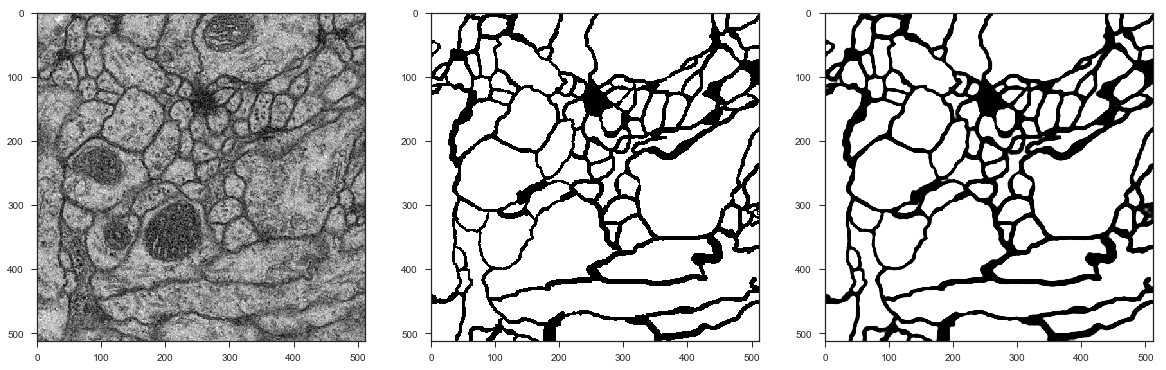

In [13]:
y_pred = model_unet_side_fuse.predict(X_train[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(X_train[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_train[0].reshape((512, 512)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')

plt.show()

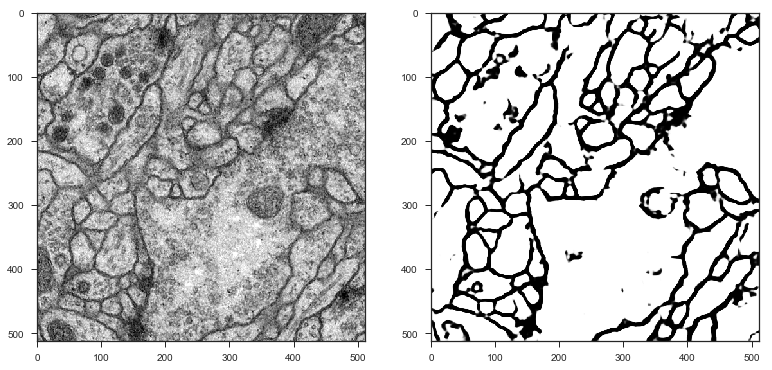

In [14]:
y_pred = model_unet_side_fuse.predict(X_test[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_pred, cmap='binary')
plt.show()
